In [22]:
# https://huggingface.co/sentence-transformers/facebook-dpr-ctx_encoder-single-nq-base <= 다음 링크를 참조하였습니다

from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
from sklearn.metrics.pairwise import cosine_similarity
import faiss

In [16]:
#코드 동작에 필요한 필수적인 변수들을 담는 class입니다.
class args:
    DATA_PATH = "../data"
    DOCUMENT_NAME = "DOC_NQ_first64.tsv"
    QUERY_TRAIN_NAME = "GTQ_NQ_train.tsv"
    QUERY_DEV_NAME = "GTQ_NQ_dev.tsv"
    TOPK = 1000
    SHORT_INFERENCE = True #시간 관계상 모든 dev query를 inferece하지 않고, 100개만 inference하는 경우 사용합니다
    SAVE_PATH = "../data/inference"
    PRED_SAVE_NAME = "DPR_Baseline.json"
    METRIC_SAVE_NAME = "DPR_Result.json"
    MODEL_TYPE_OR_DIR = 'sentence-transformers/facebook-dpr-ctx_encoder-single-nq-base' #hugginface의 다른 모델을 사용해도 가능합니다

In [3]:
#사용할 데이터들을 로드한 뒤 전처리합니다. 자세한 내용은 BM25_Baseline을 참조하세요

#======================== LOAD AND PREPROCESS ========================================#

document_corpus = pd.read_csv(f"{args.DATA_PATH}/{args.DOCUMENT_NAME}", sep="\t", dtype=str)
query_train_corpus = pd.read_csv(f"{args.DATA_PATH}/{args.QUERY_TRAIN_NAME}", sep="\t", dtype=str)
query_dev_corpus = pd.read_csv(f"{args.DATA_PATH}/{args.QUERY_DEV_NAME}", sep="\t", dtype=str)

def clean_text(text):
        text = text.replace("\n", "")
        text = text.replace("``", "")
        text = text.replace('"', "")
        text = text.replace('\'', "")
        return text.lower().strip()

#apply clean text
document_corpus['query'] = document_corpus['query'].apply(clean_text)
query_train_corpus['query'] = query_train_corpus['query'].apply(clean_text)
query_dev_corpus['query'] = query_dev_corpus['query'].apply(clean_text)

#convert to dict
document_corpus = dict(zip(document_corpus["oldid"], document_corpus['query'])) 
query_train_corpus = dict(zip(query_train_corpus["oldid"], query_train_corpus['query'])) 
query_dev_corpus = dict(zip(query_dev_corpus["oldid"], query_dev_corpus['query'])) 

#convert index to document oldid
index2oldid = {index: oldid for index, oldid in enumerate(document_corpus.keys())}

#======================== LOAD AND PREPROCESS ========================================#

In [4]:
#transformer 라이브러리를 사용한 보다 일반적인 embedding 방법입니다.
#이번 예제에서는 사용하지 않고, 더 간단한 라이브러리를 사용했습니다.
"""
from transformers import AutoTokenizer, AutoModel
import torch


def cls_pooling(model_output, attention_mask):
    return model_output[0][:,0]


# Sentences we want sentence embeddings for
sentences = ['This is an example sentence', 'Each sentence is converted']

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/facebook-dpr-ctx_encoder-single-nq-base')
model = AutoModel.from_pretrained('sentence-transformers/facebook-dpr-ctx_encoder-single-nq-base')

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling. In this case, max pooling.
sentence_embeddings = cls_pooling(model_output, encoded_input['attention_mask'])

print("Sentence embeddings:")
print(sentence_embeddings)
"""

'\nfrom transformers import AutoTokenizer, AutoModel\nimport torch\n\n\ndef cls_pooling(model_output, attention_mask):\n    return model_output[0][:,0]\n\n\n# Sentences we want sentence embeddings for\nsentences = [\'This is an example sentence\', \'Each sentence is converted\']\n\n# Load model from HuggingFace Hub\ntokenizer = AutoTokenizer.from_pretrained(\'sentence-transformers/facebook-dpr-ctx_encoder-single-nq-base\')\nmodel = AutoModel.from_pretrained(\'sentence-transformers/facebook-dpr-ctx_encoder-single-nq-base\')\n\n# Tokenize sentences\nencoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors=\'pt\')\n\n# Compute token embeddings\nwith torch.no_grad():\n    model_output = model(**encoded_input)\n\n# Perform pooling. In this case, max pooling.\nsentence_embeddings = cls_pooling(model_output, encoded_input[\'attention_mask\'])\n\nprint("Sentence embeddings:")\nprint(sentence_embeddings)\n'

In [17]:
#사용할 모델을 로드하고 올바르게 embedding되는지 테스트합니다

sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer(args.MODEL_TYPE_OR_DIR)
embeddings = model.encode(sentences)
print(embeddings.shape) #sentence 개수 * 768차원의 embedding이 생성됩니다
print(embeddings[0])

You try to use a model that was created with version 3.0.0.dev0, however, your version is 2.3.1. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





(2, 768)
[-1.94403216e-01  2.27687776e-01 -8.25039521e-02 -3.64466637e-01
 -2.61662006e-01 -2.52114851e-02  6.52471662e-01  4.12616730e-01
 -5.77716768e-01 -3.70229244e-01 -3.76033366e-01  7.65929595e-02
 -1.70670599e-01 -2.23616898e-01  4.78633016e-01 -8.73630643e-02
  4.72303391e-01  5.34237683e-01  4.07333016e-01 -6.33690178e-01
  3.89083214e-02  4.26698774e-01 -1.24221161e-01 -4.43899065e-01
  6.21124923e-01 -3.82627964e-01  3.03900093e-01 -9.34132040e-02
 -5.84829628e-01 -2.11947039e-01 -1.82397306e-01  5.09882390e-01
 -1.23635799e-01  3.96465603e-03 -2.30971038e-01 -4.14109647e-01
 -8.68620723e-02 -3.92747074e-01 -2.92386264e-02 -1.60828561e-01
 -2.31654599e-01 -5.11826694e-01  2.96584904e-01  4.56671864e-02
 -1.63985834e-01  2.61243105e-01 -1.65648282e+00 -2.21946478e-01
 -6.33026361e-01  1.88605472e-01 -7.27391481e-01  7.75409415e-02
  9.12294686e-01  9.38779861e-02 -4.05771166e-01  4.40823048e-01
 -5.43887556e-01  7.53470510e-02  1.83041036e-01 -2.12460667e-01
  1.69155017e-01

In [18]:
#모델 추론 및 시각화를 위해 함수 하나를 정의합니다

def return_rep_result(_input=None,
                      model=model,
                      ):
    
    #현재는 sentence_transformer 라이브러리를 사용하여 간결하지만, 
    #추후 transformer 라이브러리를 통한 tokenizer/model 활용도 가능합니다    
    vector_embedding = model.encode([_input])
    
    #output은 768차원의 vector입니다.
    return vector_embedding[0] #[1,768] -> [768]

In [19]:
#우리 dataset인 NQ320K에 대하여, 임의 query, document에 대해 동일 작업을 수행해 비슷한 결과가 나오는지 확인합니다


#임의의 query/answer document/ negative(정답이 아닌) document를 선택합니다
target = np.random.randint(0,100)
answer_docid, train_query = list(query_train_corpus.items())[target]
answer_document = document_corpus[answer_docid]
negative_document = document_corpus[index2oldid[np.random.randint(1000,2000)]]

#각 query/document를 embedding합니다
query_embedding = return_rep_result(_input=train_query).reshape(1,-1) #[768,] -> [1,768]
answer_document_embedding = return_rep_result(_input=answer_document).reshape(1,-1) #[768,] -> [1,768]
negative_document_embedding = return_rep_result(_input=negative_document).reshape(1,-1) #[768,] -> [1,768]


print(f"Query: {train_query}")
print(f"Answer DocID: {answer_docid}")
print(f"Answer   Document: {answer_document}")
print(f"Negative Document: {negative_document}")

print("\n","="*40,"\n")

#query와 두 document의 유사도를 계산합니다. query <-> answer document가 더 관련이 높아 더 유사도가 높은 것을 확인할 수 있습니다
print(f"Query <-> Answer   Document similarity score: {cosine_similarity(query_embedding,answer_document_embedding)}")
print(f"Query <-> Negative Document similarity score: {cosine_similarity(query_embedding,negative_document_embedding)}")

Query: who is the prime minister of republic of mauritius
Answer DocID: 72
Answer   Document: prime minister of mauritius
Negative Document: major league baseball wild card game  the major league baseball wild card game is a play - in game which was added to the major league baseball postseason in 2012 . the addition keeps the playoff format similar to the three - tiered postseason format used from 1995 through 2011 , but adds a second wild - card team . two wild - card teams in each league play each other in a single - game playoff after the end of the regular season . the winner of the game advances to face the 1st seeded team in the division series . the home team for the wild - card game is the team with the better regular - season record ( 4th seed ) .


Query <-> Answer   Document similarity score: [[0.8733525]]
Query <-> Negative Document similarity score: [[0.3777461]]


In [21]:
#document_corpus를 dense vector 형태로 생성 및 저장합니다

#@@@ 일반적으론 모든 Document에 대해 embedding vector를 저장하는 것이 정답이지만
"""
document_sparse_vector_dict = dict()
for index, (docid, document) in tqdm(enumerate(document_corpus.items()), total=len(document_corpus.items())):
    #sparse vector와 bow representation을 docid를 key로하는 dict에 저장합니다
    doc_sparse_rep, doc_bow_rep, doc_length = return_rep_result(doc=document)
    document_sparse_vector_dict[docid] = (doc_sparse_rep,doc_bow_rep)
"""

#@@@ 시간 관계상 dev_qrel과 mapping된 document만 embedding하였습니다.
document_sparse_vector_dict = dict()
for dev_index, (answer_docid, dev_query) in tqdm(enumerate(query_dev_corpus.items()), total=len(query_dev_corpus.items())):
    
    #정답이 존재하는 document만 사용합니다
    document = document_corpus.get(answer_docid)
    if document==None:
        print(f"skip {answer_docid}")
        continue

    #embedding을 저장합니다
    doc_embedding = return_rep_result(_input=document)
    document_sparse_vector_dict[answer_docid] = doc_embedding

 68%|██████▊   | 4699/6930 [01:42<00:52, 42.70it/s]

skip 78448


100%|██████████| 6930/6930 [02:35<00:00, 44.65it/s]


In [23]:
#document의 oldid를 저장하는 리스트와, sparse vector, doc_bow_rep 각각을 분리합니다
docid_list = [k for (k,v) in document_sparse_vector_dict.items()]
doc_dense_rep_list = [v.reshape(-1) for (k,v) in document_sparse_vector_dict.items()]

#faiss 통한 dense 검색을 위해, doc_dense_rep_list [# of document, dim] 크기의 np array로 변환합니다
doc_dense_rep_nparray = np.array(doc_dense_rep_list)

In [24]:
#faiss의 L2 distance ann search를 위한 환경을 구축합니다
index = faiss.IndexFlatL2(768)  # L2 distance (Euclidean distance)
index.add(doc_dense_rep_nparray)  # Add the data to the index

In [29]:
#하나의 query만 사용하여 검색이 제대로 동작하는지 확인합니다.
for dev_index, (answer_docid, dev_query) in tqdm(enumerate(query_dev_corpus.items()), total=len(query_dev_corpus.items())):
    
    #마찬가지로 query를 토큰화하여 embedding score를 구합니다
    query_embedding = return_rep_result(_input=dev_query).reshape(1,-1) #[1,768]
    
    #ANN search를 진행합니다
    distances, indices = index.search(query_embedding, k=1000)

    top_k_docid = [docid_list[idx] for idx in indices[0]] #indicies, distances는 모두 [1,Top-k] 형태입니다.
    distances = distances[0] #[1,top-k] -> [top-k]
    
    break

print("query       : ", dev_query)
print("answer docid: ",answer_docid)
print("predict list: ",top_k_docid[:10])
print("Distances   :", distances[:10])

  0%|          | 0/6930 [00:00<?, ?it/s]

query       :  who turned out to be the mother on how i met your mother
answer docid:  1
predict list:  ['1', '109368', '19775', '61204', '12258', '11396', '60828', '27924', '108424', '15299']
Distances   : [ 68.179794  93.01792   99.516464 100.617294 104.59063  108.343315
 108.55169  108.57315  110.37904  112.241295]


In [30]:
#전체 dev query set에 대하여 해당 과정을 반복합니다
#실제로 query dev set에 대하여 검색 결과를 top-1000개까지 생성한 뒤, 이를 저장합니다.
#저장 형태는 Dict[index: Tuple[정답 문서 list, 예측 문서 list]] 입니다.

result = dict()

for dev_index, (answer_docid, dev_query) in tqdm(enumerate(query_dev_corpus.items()), total=len(query_dev_corpus.items())):

    #마찬가지로 query를 토큰화하여 embedding score를 구합니다
    query_embedding = return_rep_result(_input=dev_query).reshape(1,-1) #[1,768]
    
    #ANN search를 진행합니다
    distances, indices = index.search(query_embedding, k=1000)

    top_k_docid = [docid_list[idx] for idx in indices[0]] #indicies, distances는 모두 [1,Top-k] 형태입니다.
    distances = distances[0] #[1,top-k] -> [top-k]
    
    #ranking 결과 top1000개를 Dict(answer_docid:List(preds_docid)) 형태로 저장합니다
    result[dev_index] = ([answer_docid], top_k_docid) # Dict(int: Tuple[List,List]) 
    
    if args.SHORT_INFERENCE and dev_index==99:
        break

  1%|▏         | 99/6930 [00:02<02:56, 38.62it/s]


In [31]:
#예측 결과를 확인합니다
for idx in range(10):
    print(list(result.items())[idx])

(0, (['1'], ['1', '109368', '19775', '61204', '12258', '11396', '60828', '27924', '108424', '15299', '109452', '97649', '10283', '108173', '76072', '43472', '109674', '109240', '18808', '6333', '108668', '5023', '66200', '74757', '108286', '69315', '3128', '108493', '98080', '88763', '43924', '108504', '89604', '2197', '22326', '9251', '101491', '75654', '10427', '25263', '69274', '52992', '99082', '18812', '103963', '17659', '12216', '42007', '64633', '9830', '109172', '43217', '19639', '48098', '8147', '8248', '1537', '98797', '21431', '108618', '1032', '21226', '34407', '108191', '104204', '98559', '108512', '846', '7091', '108481', '43926', '6470', '109054', '46113', '5800', '108476', '108289', '90093', '12899', '43911', '25701', '13479', '44097', '22923', '31914', '108850', '95728', '4850', '6929', '4285', '6902', '32157', '2410', '23030', '109205', '56287', '21657', '99849', '108423', '45696', '703', '5902', '108444', '27131', '19118', '22652', '109180', '65358', '11528', '6694',

In [32]:
#예측 성능을 시각화합니다. 여기서는 Recall 평가지표를 사용합니다.
def recall_at_k(relevant_docs, predicted_docs, k):
    relevant_set = set(relevant_docs)
    predicted_at_k = set(predicted_docs[:k])
    recall = len(relevant_set & predicted_at_k) / min(len(relevant_set),k)
    return recall

#Recall@K의 K값 리스트입니다.
k_values = [1, 5, 10, 50, 100, 200, 500, 1000]

results = {k: [] for k in k_values}

#각 query에 대해 recall값을 계산합니다.
for qid, (relevant, predicted) in tqdm(result.items()):
    for k in k_values:
        recall = recall_at_k(relevant, predicted, k)
        results[k].append(recall)

#K 단위로 예측한 recall 값을 평균합니다.
average_recall = {k: sum(recalls) / len(recalls) for k, recalls in results.items()}

100%|██████████| 100/100 [00:00<00:00, 7901.41it/s]


Recall@1: 0.3000
Recall@5: 0.5700
Recall@10: 0.6800
Recall@50: 0.8600
Recall@100: 0.9100
Recall@200: 0.9300
Recall@500: 0.9700
Recall@1000: 0.9800


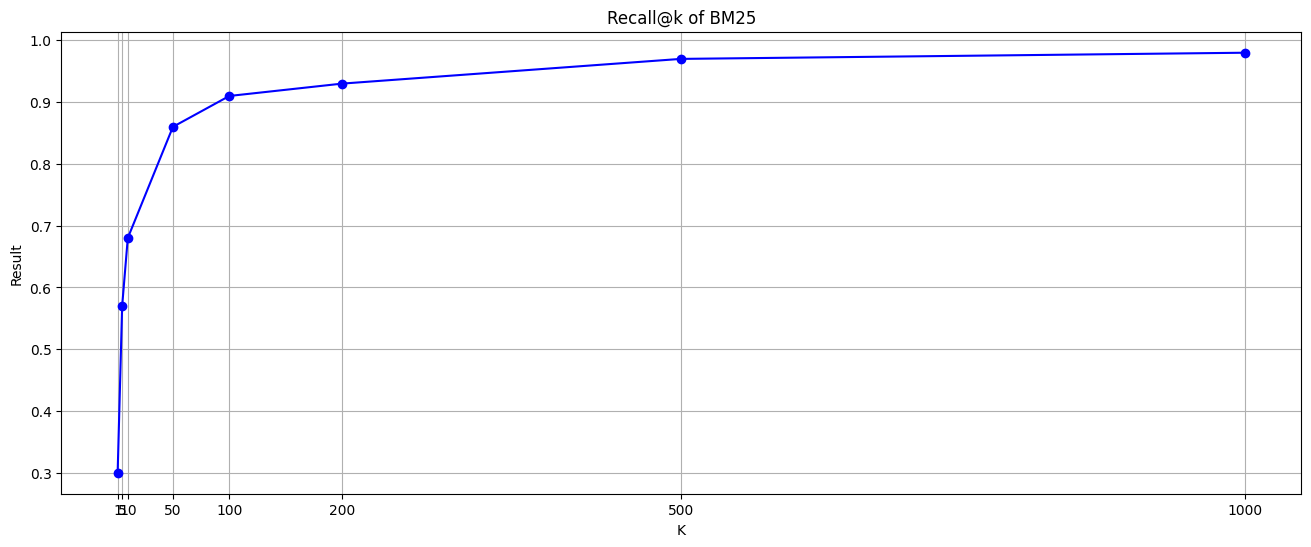

In [33]:
#결과 출력 및 시각화를 진행합니다.
for k, recall in average_recall.items():
    print(f"Recall@{k}: {recall:.4f}")

plt.figure(figsize=(16, 6))
plt.plot(list(average_recall.keys()), list(average_recall.values()), marker='o', linestyle='-', color='b')

plt.title('Recall@k of BM25')
plt.xlabel('K')
plt.ylabel('Result')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [34]:
#최종 결과를 저장합니다
with open(f"{args.SAVE_PATH}/{args.PRED_SAVE_NAME}", 'w') as f:
    json.dump(result, f)

with open(f"{args.SAVE_PATH}/{args.METRIC_SAVE_NAME}", 'w') as f:
    json.dump(average_recall, f)